In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import numpy as np
from acquire import remove_stopwords, basic_clean, tokenize , prep_and_split_data
from prepare_jag import prep_train, basic_clean3
import re
import os
from re import search
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow import keras

from nltk.corpus import stopwords
import nltk

import random
random.seed(333)

In [2]:
train_df, val_df, test_df = prep_and_split_data()

Number of rows in training set: 37931
Number of rows in validation set: 2108
Number of rows in test set: 2107


/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [3]:
train_df

,case,student_notes,clean,targets
12654,3,Mr. Hamilton is a 35 yo M presenting with 2 mo...,mr hamilton 35 yo presenting 2 months worsenin...,[fhx of pud or family history of peptic ulcer ...
35885,8,"67 yo f, c/o difficulty sleeping since 3 weeks...",67 yo f c difficulty sleeping since 3 weeks ag...,"[increased appetite, son died 3 weeks ago, fem..."
6211,3,patient is a 35 yo male with chief complaint o...,patient 35 yo male chief complaint stomach pai...,[fhx of pud or family history of peptic ulcer ...
20401,5,"26 y/o female pateint , previously healthy , p...",26 female pateint previously healthy presented...,"[onset 5 years ago, female, no caffeine use, a..."
6272,3,Pt is a 35yo male with 2 months of worsening a...,pt 35yo male 2 months worsening abdominal pain...,[fhx of pud or family history of peptic ulcer ...
...,...,...,...,...
14543,3,HPI: 35 yr old male comes with c/o abdominal p...,hpi 35 yr old male comes c abdominal pain sinc...,[fhx of pud or family history of peptic ulcer ...
14319,3,Chad Hamilton is a 35 year old male who presen...,chad hamilton 35 year old male presents stomac...,[fhx of pud or family history of peptic ulcer ...
21735,5,HPI: Ms. Whelan is a 26 year old female with ...,hpi ms whelan 26 year old female no significan...,"[onset 5 years ago, female, no caffeine use, a..."
24570,5,Patient is a 26 F who present for f/u for a re...,patient 26 f present f u recent er visit due p...,"[onset 5 years ago, female, no caffeine use, a..."


## Multi-label binarization
Let's preprocess our labels using the [StringLookup](https://keras.io/api/layers/preprocessing_layers/categorical/string_lookup) layer.

In [4]:
features = tf.ragged.constant(train_df['targets'].values)
lookup = tf.keras.layers.StringLookup(output_mode='multi_hot')
lookup.adapt(features)
vocab = lookup.get_vocabulary()

2022-02-24 13:07:25.735570: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
def invert_multi_hot(encoded_labels):
    '''Reverse a single multi-hot encoded label to a tuple of vocab terms.'''
    hot_indices = np.argwhere(encoded_labels == 1.0)[...,0]
    return np.take(vocab, hot_indices)

print('Vocabulary:\n')
print(vocab)

Vocabulary:

['[UNK]', 'female', 'nausea', '35 year', 'male', 'post prandial bloating or fullness with meals', 'nsaid use or nonsteroidal anti inflammatory drug use', 'no blood in stool', 'minimal to no change with tums', 'intermittent', 'getting worse or progressive or symptoms now daily', 'fhx of pud or family history of peptic ulcer disease', 'epigastric discomfort', 'duration 2 months', 'darker bowel movements', 'burning or gnawing or burning and gnawing', 'awakens at night', '2 to 3 beers a week', 'recent visit to emergency department with negative workup', 'onset 5 years ago', 'no illicit drug use', 'no chest pain', 'no caffeine use', 'increased stress', 'increased frequency recently', 'feels hot or feels clammy', 'fatigue or difficulty concentrating', 'episodes of heart racing', 'episodes last 15 to 30 minutes', 'episode of hand numbness or episode of finger numbness', 'associated throat tightness', 'associated sob or associated shortness of breath', 'associated nausea', 'associ

### Separate the individual targets from the label pool and then use it to represent a given label set with 0's and 1's

In [6]:
sample_label = train_df['targets'].iloc[0]
print(f'Original label: {sample_label}')

label_binarized = lookup([sample_label])
print(f'Label-binarized representation: {label_binarized}')

Original label: ['fhx of pud or family history of peptic ulcer disease', 'epigastric discomfort', 'darker bowel movements', 'nsaid use or nonsteroidal anti inflammatory drug use', 'burning or gnawing or burning and gnawing', 'post prandial bloating or fullness with meals', 'getting worse or progressive or symptoms now daily', '2 to 3 beers a week', 'male', 'duration 2 months', 'awakens at night', 'no blood in stool', 'intermittent', 'minimal to no change with tums', 'nausea', '35 year']
Label-binarized representation: [[0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


## Data preprocessing and [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) objects

In [7]:
train_df['clean'].apply(lambda x: len(x.split(" "))).describe()

count    37931.000000
mean        97.713322
std         16.372875
min          7.000000
25%         88.000000
50%        100.000000
75%        109.000000
max        150.000000
Name: clean, dtype: float64

In [8]:
max_seqlen = 98
batch_size = 128
padding_token = '<pad>'
auto = tf.data.AUTOTUNE

def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe['targets'].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe['clean'].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

## Prepare the [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) objects.

In [9]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

## Preview the dataset

In [10]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f'Student note: {text}')
    print(f'Targets: {invert_multi_hot(label[0])}')
    print(' ')

Student note: b'hpi 26 year old female complaining 5 year history palpitations states started getting worse 3 weeks ago happening often last time fingers went numb associated symptoms heat intolerance sob nausea no vomitting patients states alot stress bought condo 3 months ago lost job 2 months ago no alleviating aggravating factors denies previous episode precipitating facors skin hair changes changes bowel movements no sif pmhx fmhx none shx denies drinking smoking live alone currently unemployes'
Targets: ['female' 'recent visit to emergency department with negative workup'
 'onset 5 years ago' 'no illicit drug use' 'no chest pain'
 'no caffeine use' 'increased stress' 'increased frequency recently'
 'feels hot or feels clammy' 'fatigue or difficulty concentrating'
 'episodes of heart racing' 'episodes last 15 to 30 minutes'
 'episode of hand numbness or episode of finger numbness'
 'associated throat tightness'
 'associated sob or associated shortness of breath' 'associated nausea

## Vectorization
Vectorize the text to represent it as a quantitative value. We will use [TextVectorization layer](https://keras.io/api/layers/preprocessing_layers/text/text_vectorization)

In [11]:
# Get unique words in student notes.
vocabulary = set()
train_df['clean'].str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

42174


## Now we create our vectorization layer and map() to the [tf.data.Datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) created earlier.

In [12]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode='tf_idf'
)

with tf.device('/CPU:0'):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)

## Create a text classification model

In [13]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="softmax"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model

## Train our model

Epoch 1/10
297/297 [==============================] - 33s 108ms/step - loss: 0.0172 - categorical_accuracy: 0.2672 - val_loss: 2.7226e-04 - val_categorical_accuracy: 0.1679
Epoch 2/10
297/297 [==============================] - 35s 118ms/step - loss: 1.6789e-05 - categorical_accuracy: 0.3375 - val_loss: 2.6189e-04 - val_categorical_accuracy: 0.3529
Epoch 3/10
297/297 [==============================] - 40s 135ms/step - loss: 5.3239e-06 - categorical_accuracy: 0.3920 - val_loss: 3.3124e-04 - val_categorical_accuracy: 0.3928
Epoch 4/10
297/297 [==============================] - 38s 127ms/step - loss: 2.9535e-06 - categorical_accuracy: 0.4093 - val_loss: 3.5601e-04 - val_categorical_accuracy: 0.3966
Epoch 5/10
297/297 [==============================] - 34s 115ms/step - loss: 1.8659e-06 - categorical_accuracy: 0.4132 - val_loss: 3.7815e-04 - val_categorical_accuracy: 0.4023
Epoch 6/10
297/297 [==============================] - 33s 112ms/step - loss: 1.2619e-06 - categorical_accuracy: 0.4133 

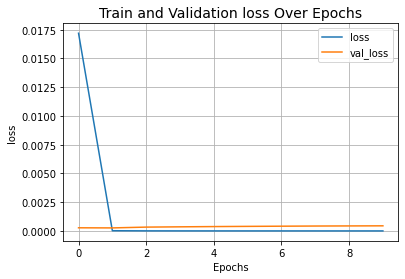

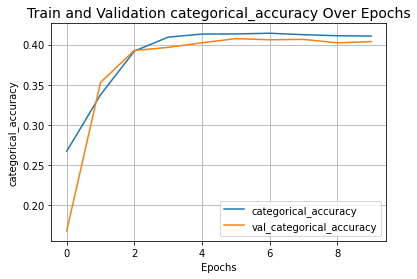

In [14]:
epochs = 10

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

## Evaluate the model

In [15]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 42174), dtype=tf.float32, name=None), TensorSpec(shape=(None, 132), dtype=tf.float32, name=None))>

In [16]:
validation_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 42174), dtype=tf.float32, name=None), TensorSpec(shape=(None, 132), dtype=tf.float32, name=None))>

In [17]:
test_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 42174), dtype=tf.float32, name=None), TensorSpec(shape=(None, 132), dtype=tf.float32, name=None))>

In [18]:
_, categorical_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

17/17 [==============================] - 1s 32ms/step - loss: 3.4764e-04 - categorical_accuracy: 0.4124
Categorical accuracy on the test set: 41.24%.


In [19]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[10:50]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Student notes: {text}")
    print(f"Targets(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    all_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
            
        )
    ][:]
    print(f"Predicted Targets(s): ({', '.join([label for label in all_labels])})")
    print(" ")

Student notes: b'26 year old female presenting evaluation palpitations past three weeks first noticed symptoms 5 years ago senior highschool symptoms eventually resolved began 3 weeks ago two weeks ago went emergency department developed numbness fingers toes epiosode concerned work ed included cardiac enzymes ecg normal explains gets symptoms feels short breath clammy nauseated sense like something bad going happen no associated chest pain symptoms start end suddenly anytime day no association exertion no recent caffeine use substance use note 3 weeks ago patient lost job pmh palpitations teenager surg no surgeries fmh no family history heart disease social history no smoking alcohol sexually active uses condoms'
Targets(s): ['nausea' '35 year' 'male' 'post prandial bloating or fullness with meals'
 'nsaid use or nonsteroidal anti inflammatory drug use'
 'no blood in stool' 'minimal to no change with tums' 'intermittent'
 'getting worse or progressive or symptoms now daily'
 'fhx of p